In [0]:
!git clone https://github.com/guilhermesartori/DatasetCafe

fatal: destination path 'DatasetCafe' already exists and is not an empty directory.


In [0]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import copy
from skimage.feature import canny
from matplotlib import cm
from skimage.viewer import ImageViewer
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.draw import circle_perimeter, ellipse_perimeter
from sklearn import neighbors
from sklearn import covariance
import numexpr as ne
from sklearn.cluster import KMeans
from skimage import io
import pandas as pd
from os import listdir
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm, datasets, metrics
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import pickle

/usr/local/lib/python3.6/dist-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')


In [0]:
def to_gray(image):
    if image.shape[-1] == 3:           
        b,g,r = cv2.split(image)
        rgb_img = cv2.merge([r,g,b])
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image
    return gray_img

def cannySciKit(source, sigma, low_threshold, high_threshold, use_quantiles):
    image = source
    gray_img = to_gray(image)

    edges = canny(gray_img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)
    plt.imshow(edges, cmap=cm.gray, aspect='equal')
    
    return edges

def cannyOpenCV(source,threshold1,threshold2,apertureSize,L2gradient):
    image = source
    edges = cv2.Canny(image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient)

    return edges

def centroid(img):
    m = cv2.moments(img)
    cx = int(m['m10']/m['m00'])
    cy = int(m['m01']/m['m00'])

    return cx, cy

def unique_count(image):
    reshaped_img = image.reshape(-1,image.shape[-1])
    colors, count = np.unique(reshaped_img, axis=0, return_counts=True)
    return colors[count.argmax()]

def bincount(image):
    img2D = image.reshape(-1, image.shape[-1])
    col_range = (256, 256, 256)
    img1D = np.ravel_multi_index(img2D.T, col_range)
    return np.unravel_index(np.bincount(img1D).argmax(), col_range)

def bincount_numexpr(image):
    img2D = image.reshape(-1, image.shape[-1])
    col_range = (256, 256, 256)
    eval_params = {'a0':img2D[:,0],'a1':img2D[:,1],'a2':img2D[:,2],
                   's0':col_range[0],'s1':col_range[1]}
    img1D = ne.evaluate('a0*s0*s1+a1*s0+a2', eval_params)
    return np.unravel_index(np.bincount(img1D).argmax(), col_range)

def kmeans_count(image):
    data = np.reshape(image, (-1,3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(data, 2, None, criteria, 10, flags)
    color = centers[0].astype(np.int32)
    if color[0] >= 165 and color[0] <= 170 and color[1] >= 110 and color[1] <= 115 and color[2] >= 45 and color[2] <= 50:
      color = centers[1].astype(np.int32)
    return color

def filter_background(bgr):
    base_b, base_g, base_r = 169, 113, 48
    thresh = 18

    b, g, r = bgr

    return not (b >= base_b-thresh and b <= base_b+thresh and 
        g >= base_g-thresh and g <= base_g+thresh and 
        r >= base_r-thresh and r <= base_r+thresh)
        
def get_image_colors(image, n_colors=3, ksize=None):
    if ksize is not None:
      image = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
    all_rgb = image.reshape(-1, 3)
    no_background = all_rgb[np.array([filter_background(row) for row in all_rgb])]
    df = pd.DataFrame(no_background,columns=['b','g','r'])
    colors_list = df.groupby(['b','g','r']).size().sort_values(ascending=False).reset_index()
    colors_list = colors_list.iloc[0:n_colors,:-1].values.reshape(-1).tolist()
    return colors_list

def remove_worst_color(colors):
    distances = np.array([0 for i in range(len(colors))])
    for i in range(len(colors)):
      for j in range(len(colors)):
        if j != i:
          distances[i] += pow(np.linalg.norm(colors[i]-colors[j]), 2)
    worst_color = distances.argmax()
    return np.delete(colors, [worst_color], axis=0)

def average_color(colors):
    average_bgr = [0, 0, 0]
    for color in colors:
        average_bgr[0] += color[0]/len(colors)
        average_bgr[1] += color[1]/len(colors)
        average_bgr[2] += color[2]/len(colors)
    
    return average_bgr

def is_impureza(img, center_distance_limit=25, contour_size_diff_limit=270, expected_max_contour_length=250, expected_min_contour_length=37, verbose=False):

  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  if verbose: 
    print('Gray scale')
    cv2_imshow(gray_img)

  center = None
  edges = None
  # Testa até encontrar um valor de threshold que nao gere imagem vazia
  threshold = 95
  while True:
    try:

      # Thresholding
      ret, thresh = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY)
      if verbose: 
        print('Threshold')
        cv2_imshow(thresh)


      # Abertura
      kernel = np.ones((4,4),np.uint8)
      opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
      if verbose:
        print('Opening')
        cv2_imshow(opening)


      # Fechamento
      kernel2 = np.ones((10,10),np.uint8)
      closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
      if verbose:
        print('Closing')
        cv2_imshow(closing)


      # Canny
      edges = cv2.Canny(closing, threshold1=90, threshold2=120, apertureSize=5, L2gradient=True)
      if verbose:
        print('Canny')
        cv2_imshow(edges)


      # Encontra o centro do objeto
      center = np.array(centroid(edges))
      if verbose:
        print('Centroid')
        centroid_image = cv2.circle(copy.deepcopy(edges), tuple(center), 3, (255, 255, 255), -1)
        cv2_imshow(centroid_image)

      break
    except ZeroDivisionError:
      threshold += 1


  # Encontra hough circle
  hough_radii = np.arange(30, 40, 1)
  hough_res = hough_circle(edges, hough_radii)
  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
  if verbose:
    print('Hough circle')
    drawn_img = color.gray2rgb(copy.deepcopy(img))
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        drawn_img[circy, circx] = (20, 220, 20)
    cv2_imshow(drawn_img)


  # Encontra os contornos do objeto
  _, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  if verbose:
    print('Contours')
    contours_image = cv2.drawContours(copy.deepcopy(img), list(contours), -1, (0,255,0), 1)
    cv2_imshow(contours_image)


  # Encontra o maior contorno
  highest_countour_length = 0
  index_of_longest_contour = -1
  for i, contour in enumerate(contours):
    contour_length = cv2.arcLength(contour, closed=True)
    if contour_length > highest_countour_length:
      highest_countour_length = contour_length
      index_of_longest_contour = i

  # Encontra as diferenças entre o comprimento do controno do objeto e cada circulo gerado a partir de cada ponto do contorno do objeto
  contour = contours[index_of_longest_contour]
  highest_length_diff = 0
  contour_length = cv2.arcLength(contour, closed=True)
  for i in range(len(contour)):
    radius = np.linalg.norm(contour[i][0]-center)
    perimeter = 2*radius*np.pi
    length_diff = abs(perimeter - contour_length)
    if length_diff > highest_length_diff:
      highest_length_diff = length_diff

  # Decide sobre o objeto
  circle_center = np.array((cx[0], cy[0]))
  object_center = np.array(center)
  distance = np.linalg.norm(object_center-circle_center)
  if distance > center_distance_limit:
    impureza = True
  elif highest_countour_length > expected_max_contour_length:
    impureza = True
  elif highest_countour_length < expected_min_contour_length:
    impureza = True
  elif highest_length_diff > contour_size_diff_limit:
    impureza = True
  else:
    impureza = False

  return impureza

def get_dataframe(ksize, n_colors, read_dataframe_from_file=True):
  if not read_dataframe_from_file:
    data = []
    
    conilon = listdir("/content/DatasetCafe/data/conilon/")
    for filename in conilon:
      image = cv2.imread("/content/DatasetCafe/data/conilon/"+filename, cv2.COLOR_BGR2RGB)
      color = list(kmeans_count(image))
      color = color + get_image_colors(image, n_colors, ksize)
      color.append(0)
      data.append(color)


    fox_bean = listdir("/content/DatasetCafe/data/fox_bean/")
    for filename in fox_bean:
      image = cv2.imread("/content/DatasetCafe/data/fox_bean/"+filename, cv2.COLOR_BGR2RGB)
      color = list(kmeans_count(image))
      color = color + get_image_colors(image, n_colors, ksize)
      color.append(1)
      data.append(color)


    moka = listdir("/content/DatasetCafe/data/moka/")
    for filename in moka:
      image = cv2.imread("/content/DatasetCafe/data/moka/"+filename, cv2.COLOR_BGR2RGB)
      color = list(kmeans_count(image))
      color = color + get_image_colors(image, n_colors, ksize)
      color.append(2)
      data.append(color)

    verde = listdir("/content/DatasetCafe/data/verde/")
    for filename in verde:
      image = cv2.imread("/content/DatasetCafe/data/verde/"+filename, cv2.COLOR_BGR2RGB)
      color = list(kmeans_count(image))
      color = color + get_image_colors(image, n_colors, ksize)
      color.append(3)
      data.append(color)

    cols = ['B', 'G', 'R']
    for i in range(n_colors):
      cols.append(f'B{i}')
      cols.append(f'G{i}')
      cols.append(f'R{i}')

    cols.append('Tipo')

    dataframe = pd.DataFrame(data, columns = cols)

    dataframe.to_csv("dataframe.csv", index=False)
  else:
    dataframe = pd.read_csv("dataframe.csv")
  return dataframe

def get_model(ksize, n_colors, read_model_file=True, read_dataframe_from_file=True):
  model = None
  dataframe = get_dataframe(ksize, n_colors, read_dataframe_from_file)
  x = dataframe.drop('Tipo', axis=1)
  y = dataframe[['Tipo']]
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.2)
  if not read_model_file:
    matrix = np.linalg.inv(covariance.empirical_covariance(x_train))

    model = neighbors.KNeighborsClassifier(n_neighbors=15, metric='mahalanobis', metric_params={'VI': matrix})
    model.fit(x_train, np.ravel(y_train))
    
    with open("type_prediction_model.pickle", "wb") as f:
      pickle.dump(model, f)
  
  else:
    with open("type_prediction_model.pickle", "rb") as f:
      model = pickle.load(f)

  return model, dataframe, x_train, x_test, y_train, y_test

def acc_classificador_impurezas():
  acertos = 0
  tentativas = 0

  impurezas = listdir("/content/DatasetCafe/data/impureza/")
  for filename in impurezas:
    image = cv2.imread("/content/DatasetCafe/data/impureza/"+filename, cv2.COLOR_BGR2RGB)
    tentativas += 1
    if is_impureza(image):
      acertos += 1
  print(f'Impureza: {acertos} acertos, {tentativas-acertos} erros, total {acertos/tentativas}')

  acertos_por_classe = 0
  tentativas_por_classe = 0
  conilon = listdir("/content/DatasetCafe/data/conilon/")
  for filename in conilon:
    image = cv2.imread("/content/DatasetCafe/data/conilon/"+filename, cv2.COLOR_BGR2RGB)
    tentativas += 1
    tentativas_por_classe += 1
    if not is_impureza(image):
      acertos += 1
      acertos_por_classe += 1
  print(f'Conilon: {acertos_por_classe} acertos, {tentativas_por_classe-acertos_por_classe} erros, total {acertos_por_classe/tentativas_por_classe}')
  print(f'Conilon: {acertos} acertos, {tentativas-acertos} erros, total {acertos/tentativas}')

  acertos_por_classe = 0
  tentativas_por_classe = 0
  fox_bean = listdir("/content/DatasetCafe/data/fox_bean/")
  for filename in fox_bean:
    image = cv2.imread("/content/DatasetCafe/data/fox_bean/"+filename, cv2.COLOR_BGR2RGB)
    tentativas += 1
    tentativas_por_classe += 1
    if not is_impureza(image):
      acertos += 1
      acertos_por_classe += 1
  print(f'Fox-bean: {acertos_por_classe} acertos, {tentativas_por_classe-acertos_por_classe} erros, total {acertos_por_classe/tentativas_por_classe}')
  print(f'Fox-bean: {acertos} acertos, {tentativas-acertos} erros, total {acertos/tentativas}')

  acertos_por_classe = 0
  tentativas_por_classe = 0
  moka = listdir("/content/DatasetCafe/data/moka/")
  for filename in moka:
    image = cv2.imread("/content/DatasetCafe/data/moka/"+filename, cv2.COLOR_BGR2RGB)
    tentativas += 1
    tentativas_por_classe += 1
    if not is_impureza(image):
      acertos += 1
      acertos_por_classe += 1
  print(f'Moka: {acertos_por_classe} acertos, {tentativas_por_classe-acertos_por_classe} erros, total {acertos_por_classe/tentativas_por_classe}')
  print(f'Moka: {acertos} acertos, {tentativas-acertos} erros, total {acertos/tentativas}')

  acertos_por_classe = 0
  tentativas_por_classe = 0
  verde = listdir("/content/DatasetCafe/data/verde/")
  for filename in verde:
    image = cv2.imread("/content/DatasetCafe/data/verde/"+filename, cv2.COLOR_BGR2RGB)
    tentativas += 1
    tentativas_por_classe += 1
    if not is_impureza(image):
      acertos += 1
      acertos_por_classe += 1
  print(f'Verde: {acertos_por_classe} acertos, {tentativas_por_classe-acertos_por_classe} erros, total {acertos_por_classe/tentativas_por_classe}')
  print(f'Verde: {acertos} acertos, {tentativas-acertos} erros, total {acertos/tentativas}')

  print(f'TOTAL: {acertos} acertos, {tentativas-acertos} erros, total {acertos/tentativas}')

  return acertos/tentativas

In [0]:
tipos = ['conilon', 'fox_bean', 'moka', 'verde']
n_colors = 1
ksize = 2

model, \
dataframe, \
x_train, \
x_test, \
y_train, \
y_test = get_model(ksize, n_colors, read_model_file=False, read_dataframe_from_file=False)

scores = cross_val_score(model, x_train, np.ravel(y_train), cv=10)
print(scores.mean())

y_prediction = model.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_prediction)
print(accuracy)
print(classification_report(y_test, y_prediction))
print(confusion_matrix(y_test, y_prediction))

0.8081633459835545
0.8375
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        19
           1       0.72      0.76      0.74        17
           2       0.83      1.00      0.91        20
           3       1.00      0.83      0.91        24

    accuracy                           0.84        80
   macro avg       0.83      0.83      0.83        80
weighted avg       0.85      0.84      0.84        80

[[14  5  0  0]
 [ 4 13  0  0]
 [ 0  0 20  0]
 [ 0  0  4 20]]


In [0]:
acc = acc_classificador_impurezas()
print(acc)

Impureza: 69 acertos, 31 erros, total 0.69
Conilon: 66 acertos, 34 erros, total 0.66
Conilon: 135 acertos, 65 erros, total 0.675
Fox-bean: 71 acertos, 29 erros, total 0.71
Fox-bean: 206 acertos, 94 erros, total 0.6866666666666666
Moka: 87 acertos, 13 erros, total 0.87
Moka: 293 acertos, 107 erros, total 0.7325
Verde: 65 acertos, 35 erros, total 0.65
Verde: 358 acertos, 142 erros, total 0.716
TOTAL: 358 acertos, 142 erros, total 0.716
0.716


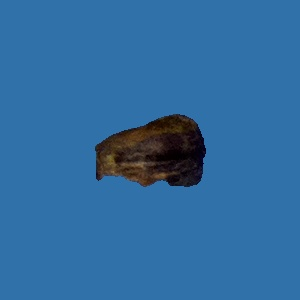

In [0]:
img = cv2.imread("/content/DatasetCafe/data/impureza/impureza_105.jpg", cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
gray_blur = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)

Gray scale


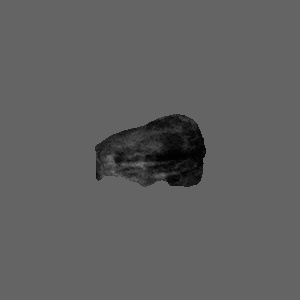

Threshold


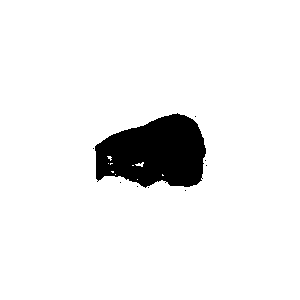

Opening


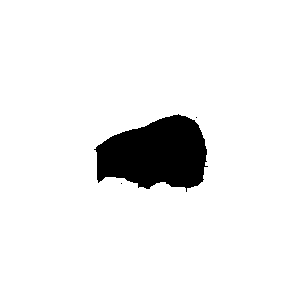

Closing


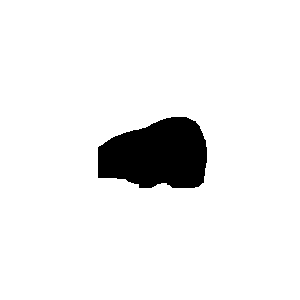

Canny


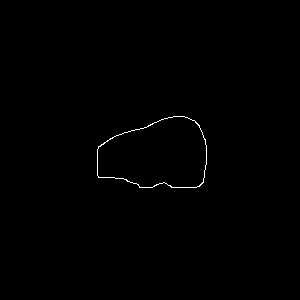

Centroid


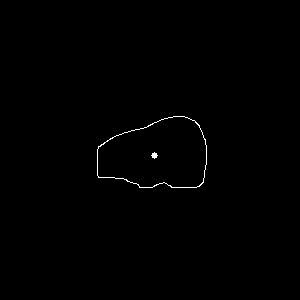

Hough circle


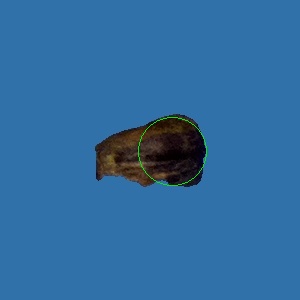

Contours


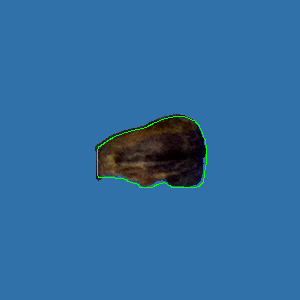

impureza


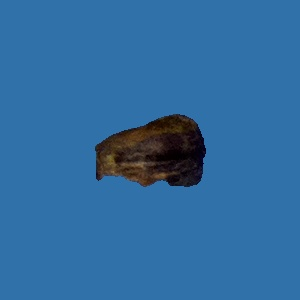

In [0]:
# output

if is_impureza(img, verbose=True):
  print("impureza")
else:
  img_colors = [list(kmeans_count(blur)) + get_image_colors(blur, n_colors, ksize)]
  pred = model.predict(img_colors)[0]
  print(tipos[pred])
cv2_imshow(img)